In [1]:
#### This part is about training a Siamemese network on a syntethic dataset created from MNIST for Color histogram ####
####                                   differentiation                                                             ####

In [4]:
#### Importing libraries

import torch
import cv2
import time
import os
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from bokeh.plotting import figure, show
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D            # pooling
from tensorflow.keras.layers import Concatenate             # merge
from tensorflow.keras.layers import Lambda, Flatten, Dense  # core
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

In [6]:
### We will use the MNIST Dataset from Keras

output_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\notebook\Deep_Model\output"
weigths_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\notebook\Deep_Model\weights"

In [648]:
### Loading datas
## from mnist

# the data, split between train and test sets
(xtrain_m, ytrain_m), (xtest_m, ytest_m) = mnist.load_data()
xtrain_m = xtrain_m.astype('float32')
xtest_m  = xtest_m.astype('float32')
xtrain_m /= 255
xtest_m  /= 255



In [649]:
xtrain_m.shape

(60000, 28, 28)

In [650]:
##  Saving training datas

with open(os.path.join(output_path,"train_mnist.pickle"), "wb") as f:
    pickle.dump((xtrain_m,ytrain_m),f)

In [651]:
##  Saving testing datas

with open(os.path.join(output_path,"test_mnist.pickle"), "wb") as f:
    pickle.dump((xtest_m,ytest_m),f)

In [1]:
##  Fonctions to initialize bias for trainig

def initialize_bias(shape, name=None, dtype = None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [2]:
##  Fonctions to initialize weights for trainig

def initialize_weights(shape, name=None, dtype = None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [3]:
## Function for L_2 distance between tensors

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [7]:
# First Model with a well known architecture for feature extraction 

In [8]:
###  Construction of a siamese network, the bemlow one is popular for CNN tasks
###  We modifies the layers inputs to make it usables for our task

def get_siamese_model_compatible(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (2,2), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (2,2), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


In [9]:
model = get_siamese_model_compatible((30, 30, 1))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         1382528     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambd

In [10]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
## Load training and testing datas 
## from mnist
with open(os.path.join(output_path, "train_mnist.pickle"), "rb") as f:
    (xtrain_m, ytrain_m) = pickle.load(f)
    
    
with open(os.path.join(output_path, "test_mnist.pickle"), "rb") as f:
    (xtest_m, ytest_m) = pickle.load(f)

In [8]:
xtrain_m.shape

(60000, 28, 28)

In [ ]:
## create pairs for mnist train and testing

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [661]:
# create training and test positive and negative pairs

num_classes = 10

digit_indices = [np.where(ytrain_m == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(xtrain_m, digit_indices)

digit_indices = [np.where(ytest_m == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(xtest_m, digit_indices)


0
17820


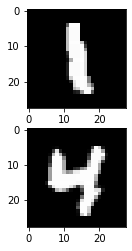

In [662]:
ind = 1807
#plt.imshow(te_pairs[8950][1], cmap = "gray")

print(te_y[ind])
print(len(te_pairs))

image_pair = te_pairs[ind]
#plt.imshow(image_pair[0], cmap = plt.cm.gray)
plt.subplot(211)
plt.imshow(image_pair[0], cmap = plt.cm.gray)

plt.subplot(212)
plt.imshow(image_pair[1], cmap = plt.cm.gray)

plt.show()

In [663]:
# train
#rms = RMSprop()
#model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
#model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#          batch_size=128,
#          epochs=epochs,
#          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

In [21]:
#### Functions from processing mnist database images in order to produce synthesis histrogram datas for our model

def process_digit(digit_image):

    digit_image = digit_image.astype(np.float32) / 255

    rd = np.random.rand((6))
    bool_list = rd > 0.4
    
    use_GBlur,use_dilate,do_closig,use_MBlur,do_erode_first,do_erode_second = bool_list

    target_shape = (30,30)
    digit_image = cv2.resize(digit_image, target_shape)

    if(use_GBlur):
        digit_image = cv2.GaussianBlur(digit_image, (5,5), cv2.BORDER_DEFAULT)

    if(use_dilate):
        kernel = np.ones((2,2), np.uint8)
        digit_image = cv2.dilate(digit_image, kernel, iterations = 1)

    if(do_closig):
        kernel = np.ones((3,3), np.uint8)
        digit_image = cv2.morphologyEx(digit_image, cv2.MORPH_CLOSE, kernel)

    if(use_MBlur):
        digit_image = cv2.medianBlur(digit_image, 5)
        
    if(do_erode_first):
        kernel = np.ones((2,2), np.uint8)
        digit_image = cv2.erode(digit_image, kernel)

    if(do_erode_second):
        kernel = np.ones((3,3), np.uint8)
        digit_image = cv2.erode(digit_image, kernel)

    return bool_list, digit_image


[ True  True  True  True False  True]
(30, 30)


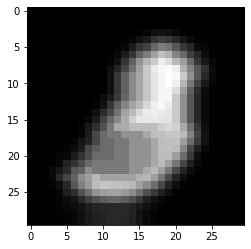

In [665]:
## Create joined dataset and process inputs to have histograms
# for now we will only use MNIST

bool_s, image = process_digit(te_pairs[6859][0])
plt.imshow(image, cmap = plt.cm.gray)
print(bool_s)
print(image.shape)


In [666]:
# (inputs,targets) from digits dataset 
# (tre_pair,tr_y) from mnist dataset

print(len(tr_pairs),len(tr_y))

108400 108400


In [12]:
#### Function we will use tho process bothimages of a pair with the same operation in order to preserve similarities

def process_digit_pair(digit_image_pair):
    
    digit_image_pair_res = [0,1]
    digit_image_pair_res[0] = digit_image_pair[0].astype(np.float32) / 255
    digit_image_pair_res[1] = digit_image_pair[1].astype(np.float32) / 255

    
    rd = np.random.rand((6))
    bool_list = rd > 0.3
    
    use_GBlur,use_dilate,do_closig,use_MBlur,do_erode_first,do_erode_second = bool_list

    target_shape = (30,30)
    for i in range(2):
        digit_image = cv2.resize(digit_image_pair[i], target_shape)

        if(use_GBlur):
            digit_image = cv2.GaussianBlur(digit_image, (5,5), cv2.BORDER_DEFAULT)

        if(use_dilate):
            kernel = np.ones((2,2), np.uint8)
            digit_image = cv2.dilate(digit_image, kernel, iterations = 1)

        if(do_closig):
            kernel = np.ones((3,3), np.uint8)
            digit_image = cv2.morphologyEx(digit_image, cv2.MORPH_CLOSE, kernel)

        if(use_MBlur):
            digit_image = cv2.medianBlur(digit_image, 5)

        if(do_erode_first):
            kernel = np.ones((3,3), np.uint8)
            digit_image = cv2.erode(digit_image, kernel)

        if(do_erode_second):
            kernel = np.ones((3,3), np.uint8)
            digit_image = cv2.erode(digit_image, kernel)
            
        digit_image_pair_res[i] = digit_image

    return bool_list, digit_image_pair_res


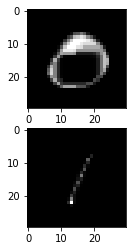

[False  True False  True  True  True]
0


In [668]:
ind = 7095
bool_s, image_pair = process_digit_pair(tr_pairs[ind])
#plt.imshow(image_pair[0], cmap = plt.cm.gray)
plt.subplot(211)
plt.imshow(image_pair[0], cmap = plt.cm.gray)

plt.subplot(212)
plt.imshow(image_pair[1], cmap = plt.cm.gray)

plt.show()
print(bool_s)
print(tr_y[ind])

In [669]:
## adapt datas from Mnist , Synthetisation for histogram data
#tr_pairs, tr_y
tr_pairs_proceded = []
for ind in range(len(tr_pairs)):
    bool_s, image_pair = process_digit_pair(tr_pairs[ind])
    tr_pairs_proceded.append(image_pair)

tr_y_proceded = tr_y
    
#te_pairs, te_y
te_pairs_proceded = []
for ind in range(len(te_pairs)):
    bool_s, image_pair = process_digit_pair(te_pairs[ind])
    te_pairs_proceded.append(image_pair)
    
te_y_proceded = te_y

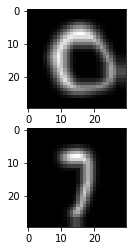

0


In [670]:
ind = 1927

image_pair = tr_pairs_proceded[ind]
plt.subplot(211)
plt.imshow(image_pair[0], cmap = plt.cm.gray)

plt.subplot(212)
plt.imshow(image_pair[1], cmap = plt.cm.gray)

plt.show()
print(tr_y_proceded[ind])

In [671]:
tr_pairs_proceded = np.array(tr_pairs_proceded)
te_pairs_proceded = np.array(te_pairs_proceded)

In [672]:
tr_pairs_proceded.shape

(108400, 2, 30, 30)

In [23]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)


In [600]:
### Training step

epochs = 20

model.fit([tr_pairs_proceded[:, 0].reshape(108400,30,30,1), tr_pairs_proceded[:, 1].reshape(108400,30,30,1)], tr_y_proceded,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs_proceded[:, 0].reshape(17820,30,30,1), te_pairs_proceded[:, 1].reshape(17820,30,30,1)], te_y_proceded))


Train on 114181 samples, validate on 18891 samples
Epoch 1/10
114181/114181 [==============================] - 692s 6ms/sample - loss: 0.3480 - val_loss: 0.3359
Epoch 2/10
114181/114181 [==============================] - 728s 6ms/sample - loss: 0.3294 - val_loss: 0.3283
Epoch 3/10
114181/114181 [==============================] - 701s 6ms/sample - loss: 0.3218 - val_loss: 0.3236
Epoch 4/10
114181/114181 [==============================] - 633s 6ms/sample - loss: 0.3173 - val_loss: 0.3217
Epoch 5/10
114181/114181 [==============================] - 634s 6ms/sample - loss: 0.3126 - val_loss: 0.3178
Epoch 6/10
114181/114181 [==============================] - 601s 5ms/sample - loss: 0.3092 - val_loss: 0.3130
Epoch 7/10
114181/114181 [==============================] - 585s 5ms/sample - loss: 0.3057 - val_loss: 0.3132
Epoch 8/10
114181/114181 [==============================] - 582s 5ms/sample - loss: 0.3020 - val_loss: 0.3112
Epoch 9/10
114181/114181 [==============================] - 583s 5ms/

In [673]:
### Saving the model

#from tensorflow.keras.models import load_model
model.save(os.path.join(weigths_path, 'model_siamese_first.h5'))

In [15]:
### Loading the model

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
#help(tf.keras.initialisations)
with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias}):
    loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_first.h5'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
loadded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         1382528     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [677]:
# Compute final accuracy on training and test sets

y_pred = model.predict([tr_pairs_proceded[:, 0].reshape(108400,30,30,1), tr_pairs_proceded[:, 1].reshape(108400,30,30,1)])
tr_acc = compute_accuracy(tr_y_proceded, y_pred)
y_pred = model.predict([te_pairs_proceded[:, 0].reshape(17820,30,30,1), te_pairs_proceded[:, 1].reshape(17820,30,30,1)])
te_acc = compute_accuracy(te_y_proceded, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 93.49%
* Accuracy on test set: 93.23%


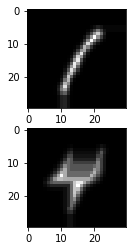

0
Prediction with siamese network 0.0037182376254349947
Correlation distance = 0.38779598378359476


In [685]:
### Observation of the correctness of the model

ind = 11001
image_pair = tr_pairs_proceded[ind]
plt.subplot(211)
plt.imshow(image_pair[0], cmap = plt.cm.gray)

plt.subplot(212)
plt.imshow(image_pair[1], cmap = plt.cm.gray)

plt.show()
print(tr_y_proceded[ind])

#print(tr_pairs_proceded[ind, 0].reshape(1,30,30,1).shape)
prediction = loadded_model.predict([tr_pairs_proceded[ind, 0].reshape(1,30,30,1), tr_pairs_proceded[ind, 1].reshape(1,30,30,1)])

distance = dist = cv2.compareHist(tr_pairs_proceded[ind, 0], tr_pairs_proceded[ind, 1], cv2.HISTCMP_CORREL)

print("Prediction with siamese network {}".format(prediction[0,0]))

print("Correlation distance = {}".format(distance))

In [18]:
# Second base_model using a minimal architecture for improving performance

In [9]:
## We define a new create_pair method for data labelling

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
        # We reuse the non used rest
        for i in range(n+1, len(digit_indices[d])-1):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            labels += [0]
            
    return np.array(pairs), np.array(labels)


In [10]:
# create training+test positive and negative pairs

num_classes = 10

digit_indices = [np.where(ytrain_m == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(xtrain_m, digit_indices)

digit_indices = [np.where(ytest_m == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(xtest_m, digit_indices)


In [13]:
## adapt datas from Mnist , Synthetisation for histogram data
#tr_pairs, tr_y
tr_pairs_proceded = []
for ind in range(len(tr_pairs)):
    bool_s, image_pair = process_digit_pair(tr_pairs[ind])
    tr_pairs_proceded.append(image_pair)

tr_y_proceded = tr_y
    
#te_pairs, te_y
te_pairs_proceded = []
for ind in range(len(te_pairs)):
    bool_s, image_pair = process_digit_pair(te_pairs[ind])
    te_pairs_proceded.append(image_pair)
    
te_y_proceded = te_y

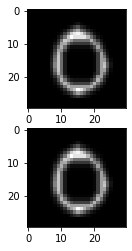

1


In [14]:
ind = 7096

image_pair = tr_pairs_proceded[ind]
plt.subplot(211)
plt.imshow(image_pair[0], cmap = plt.cm.gray)

plt.subplot(212)
plt.imshow(image_pair[1], cmap = plt.cm.gray)

plt.show()
print(tr_y_proceded[ind])

In [15]:
tr_pairs_proceded = np.array(tr_pairs_proceded)
te_pairs_proceded = np.array(te_pairs_proceded)

In [16]:
tr_pairs_proceded.shape

(114181, 2, 30, 30)

In [17]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [18]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
#from keras.datasets import mnist
#from keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

num_classes = 10
epochs = 50




def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


input_shape = (30,30,1)
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

#def euclidean_distance(vects):
#    x, y = vects
#    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
#    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Add a customized layer to compute the absolute difference between the encodings
L2_layer = Lambda(lambda tensors:K.sqrt(K.maximum(K.sum(K.square(tensors[0] - tensors[1]), axis=1, keepdims=True), K.epsilon())))
distance = L2_layer([processed_a, processed_b])


#distance = Lambda(euclidean_distance,
#                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model_m = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model_m.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model_m.fit([tr_pairs_proceded[:, 0].reshape(114181,30,30,1), tr_pairs_proceded[:, 1].reshape(114181,30,30,1)], tr_y_proceded,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs_proceded[:, 0].reshape(18891,30,30,1), te_pairs_proceded[:, 1].reshape(18891,30,30,1)], te_y_proceded))



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 114181 samples, validate on 18891 samples
Epoch 1/50
114181/114181 [==============================] - 22s 191us/sample - loss: 0.0500 - accuracy: 0.9590 - val_loss: 0.0219 - val_accuracy: 0.9681
Epoch 2/50
114181/114181 [==============================] - 9s 79us/sample - loss: 0.0286 - accuracy: 0.9819 - val_loss: 0.0170 - val_accuracy: 0.9744
Epoch 3/50
114181/114181 [==============================] - 9s 78us/sample - loss: 0.0245 - accuracy: 0.9844 - val_loss: 0.0155 - val_accuracy: 0.9765
Epoch 4/50
114181/114181 [==============================] - 9s 77us/sample - loss: 0.0221 - accuracy: 0.9854 - val_loss: 0.0153 - val_accuracy: 0.9771
Epoch 5/50
114181/114181 [==============================] - 9s 77us/sample - loss: 0.0207 - accuracy: 0.9864 - val_loss: 0.0148 - val_accuracy: 0.9784
Epoch 6/50
114181

Epoch 50/50
114181/114181 [==============================] - 8s 73us/sample - loss: 0.0136 - accuracy: 0.9891 - val_loss: 0.0128 - val_accuracy: 0.9837


In [31]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


# compute final accuracy on training and test sets
y_pred = model_m.predict([tr_pairs_proceded[:, 0].reshape(114181,30,30,1), tr_pairs_proceded[:, 1].reshape(114181,30,30,1)])
tr_acc = compute_accuracy(tr_y_proceded, y_pred)
y_pred = model_m.predict([te_pairs_proceded[:, 0].reshape(18891,30,30,1), te_pairs_proceded[:, 1].reshape(18891,30,30,1)])
te_acc = compute_accuracy(te_y_proceded, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.17%
* Accuracy on test set: 98.50%


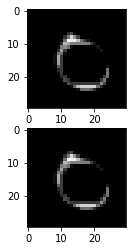

1
Prediction with siamese network 0.9996837722428609
Correlation distance = 1.0


In [23]:
ind = 114  #11111
image_pair = tr_pairs_proceded[ind]
plt.subplot(211)
plt.imshow(image_pair[0], cmap = plt.cm.gray)

plt.subplot(212)
plt.imshow(image_pair[1], cmap = plt.cm.gray)

plt.show()
print(tr_y_proceded[ind])

#print(tr_pairs_proceded[ind, 0].reshape(1,30,30,1).shape)
prediction = model_m.predict([tr_pairs_proceded[ind, 0].reshape(1,30,30,1), tr_pairs_proceded[ind, 1].reshape(1,30,30,1)])

distance = dist = cv2.compareHist(tr_pairs_proceded[ind, 0], tr_pairs_proceded[ind, 1], cv2.HISTCMP_CORREL)

print("Prediction with siamese network {}".format(1 - prediction[0,0]))

print("Correlation distance = {}".format(distance))

In [24]:
# Save the Network

from tensorflow.keras.models import load_model
model_m.save(os.path.join(weigths_path, 'model_siamese.h5'))

In [33]:
from tensorflow.keras.utils import CustomObjectScope
#help(tf.keras.initialisations)
with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
    loadded_model = load_model(os.path.join(weigths_path, 'model_siamese.h5'))

In [34]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


# compute final accuracy on training and test sets
y_pred = loadded_model.predict([tr_pairs_proceded[:, 0].reshape(114181,30,30,1), tr_pairs_proceded[:, 1].reshape(114181,30,30,1)])
tr_acc = compute_accuracy(tr_y_proceded, y_pred)
y_pred = loadded_model.predict([te_pairs_proceded[:, 0].reshape(18891,30,30,1), te_pairs_proceded[:, 1].reshape(18891,30,30,1)])
te_acc = compute_accuracy(te_y_proceded, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.17%
* Accuracy on test set: 98.50%
